### Réalisé par :
AIT AMARA Mohamed, 181831072170

BOUROUINA Rania, 181831052716

CHIBANE Ilies, 181831072041

HAMMAL Ayoub, 181831048403

# TP 6 Réseaux de neurones - Multi classification et Propagation en arrière
Dans ce TP, nous aimerions entrainer un réseau de neurones pour la tâche de classification en utilisant l'algorithme d propagation en arrière (backpropagation).

L'ensemble de données que nous allons utiliser est le même que celui utilisé durant le TP1, i.e. les images de chiffres manuscrits.


# Importation des librairies necessaires au travail

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import cv2

from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier

# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [2]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
data.shape

(5000, 401)

Dans ces données (data), les 400 premières colonnes representent les pixels de l'image (20x20), la dernière colonne represente la classe de l'image (chiffres de 0 à 9). (http://yann.lecun.com/exdb/mnist/)

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [3]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,:-1]))
y=data[:,-1]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [4]:
print('X', X.shape ,' y ', y.shape)

X (5000, 401)  y  (5000, 1)


Visualisation aléatoire de quelques données

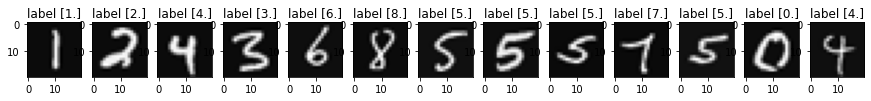

In [5]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,1:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(y[c]))
    plt.imshow(a,cmap='gray')

Transformer y de tel sorte à avoir un vecteur pour chaque exemple

Equivalent de tocategorical

In [6]:
YY=np.zeros((y.shape[0], int(np.max(y))+1))
YY.shape

(5000, 10)

In [7]:
for i in range (YY.shape[0]):
    YY[i,int(y[i])]=1

# Réseaux de neurones
Pour cette partie, nous choisissons une réseau simple:

- une couche d'entrée avec 400 noeuds (20 x 20 pixels) + le biais
- une couche cachée avec 25 noeuds
- une couche de sortie avec 10 noeuds (nombre de classes)

In [8]:
# poids de la couche 1
W1 = np.genfromtxt('W1.csv', delimiter=',', dtype=float)
W1.shape


(25, 401)

In [9]:
# poids de la couche 2
W2 = np.genfromtxt('W2.csv', delimiter=',', dtype=float)
W2.shape

(10, 26)

In [10]:
input_layer_size  = 400;  
hidden_layer_size = 25;   
num_labels = 10;

# Calcul du coût

# TODO  1 calcul du coût
**Tâche 1**: Modifier la fonction computeCost afin d'obtenir un coût avec régularisation

Rappelons que le coût avec régularisation est calculé comme suit:

$ J(\theta)= \frac{1}{m} \sum_{i=1}^m\sum_{k=1}^K \left[ -y_k^{(i)} \log (h_\theta(x^{(i)}) )_k - (1-y_k^{(i)}) \log (1-h_\theta(x^{(i)}) )_k \right] + \frac{\lambda}{2m} \left[ \sum_{j=1}^{25}\sum_{k=1}^{400} \left( \theta_{j,k}^{(1)} \right)^2 +   \sum_{j=1}^{10}\sum_{k=1}^{25} \left( \theta_{j,k}^{(2)} \right)^2 \right] $

In [11]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1 / (1 + np.exp(-z));

In [12]:
def computeCost(X, YY, theta1, theta2, hidden_layer_size, lambda_):
    a1 = X

    z2 = np.zeros((X.shape[0], hidden_layer_size))
    a2 = np.zeros((X.shape[0], hidden_layer_size))

    intercept = np.ones((X.shape[0], 1))
    z2 = np.column_stack((intercept, np.matmul(a1, np.transpose(theta1))))
    a2 = Sigmoid(z2)
    a2[:, 0] = 1

    z3 = np.zeros((YY.shape[0], YY.shape[1]))
    a3 = np.zeros((YY.shape[0], YY.shape[1]))

    z3 = np.matmul(a2, np.transpose(theta2))
    a3 = Sigmoid(z3)

    J = np.zeros((YY.shape[0],1))
    J = (1 / y.shape[0]) * (np.sum(np.sum((-YY * np.log(a3)) - ((1 - YY) * np.log(1 - a3))))) + \
        (lambda_ / (2 * X.shape[0])) * (np.power(theta1[:, 1:], 2).sum() + np.power(theta2[:, 1:], 2).sum())

    return J

# TODO  2 calcul du gradient
**Tâche 2**: Implémenter la fonction NNCostFunction afin de retourner:

- Le coût avec régularisation
- Le gardient du coût par rapport à chaqu'un des paramètres du réseau

Rappelons le gradient de la sigmoid:

$ sigmoid(z) =\sigma(z)= \frac{1}{1-e^{-z}}$

$ \sigma(z)^\prime = \sigma(z)(1-\sigma(z)) =a(1-a)$ tel que $a$ est l'activation d'une couche donnée

L'algorithme à implementer est comme suit:

Pour chaque exemple de l'ensemble d'apprentissage faire

Pour chaque noeud de la couche de sortie, calculer la dérivée (gradient):

$\delta_k^{(3)} = \left( a_k^{(3)}- y_k \right)  $

Pour chaque noeud de la couche caché calculer la dérivée (gradient):

$\delta^{(2)} =  \left(\Theta^{(2)}\right)^T \delta^{(3)} \quad .* \quad \sigma^\prime\left(z^{(2)} \right) $

Notons que l'opérateur $.*$ represente la multiplication élement par élement et non pas la multiplication matricielle

Le gradient de chaque noeud et de chaque couche sera finalement:

$\Delta^{(l)} =  \Delta^{(l)} + \delta^{(l)} * \left( a^{(l)} \right)^T $

Fin pour

Fin pour

Diviser le gradient cumulé par le nombre d'exemples:

$ \frac{\partial J(\Theta)} { \partial \Theta_{i,j)}^{(l)}} = \frac{1}{m} \Delta_{i,j)}^{(l)}$


In [13]:
def NNCostFunction(X, YY, theta1, theta2, hidden_layer_size, lambda_ = 0):
    a1 = X # 5000x401
    z2 = X @ theta1.T # 5000x401 @ 401x25 = 5000x25
    a2 = np.column_stack((np.ones((z2.shape[0], 1)), Sigmoid(z2))) # 5000x26

    z3 = a2 @ theta2.T # 5000x26 @ 26x10 = 5000x10
    a3 = Sigmoid(z3) # 5000x10

    delta3 = a3 - YY # 5000x10

    delta2 = ((delta3 @ theta2) * a2 * (1 - a2))[:, 1:] # 5000x25 | il y a que 25 neurones, le dernier delta est celui du biais de la deuxième couche

    theta2_grad = (np.broadcast_to(delta3[:, :, np.newaxis], (*delta3.shape, a2.shape[1])) \
        * np.broadcast_to(a2[:, np.newaxis, :], (a2.shape[0], delta3.shape[1], a2.shape[1]))).mean(axis=0) \
        + (lambda_ / X.shape[0]) * np.column_stack((np.zeros((theta2.shape[0], 1)), theta2[:, 1:])) # 10x26

    theta1_grad = (np.broadcast_to(delta2[:, :, np.newaxis], (*delta2.shape, a1.shape[1])) \
        * np.broadcast_to(a1[:, np.newaxis, :], (a1.shape[0], delta2.shape[1], a1.shape[1]))).mean(axis=0) \
        + (lambda_ / X.shape[0]) * np.column_stack((np.zeros((theta1.shape[0], 1)), theta1[:, 1:])) # 25X401

    J = computeCost(X, YY, theta1, theta2, hidden_layer_size, lambda_)
    
    return J, [theta1_grad, theta2_grad]

# TODO  3 entrainement du réseau
**Tâche 3**: Entrainer le réseau en utilisant la descente du gradient:
Ici il faudra reprendre l'algorithme de la descente du gradient afin de mettre à jour les paramètres du réseau


In [14]:
def gradientDescent(X, y, theta, alpha, iterations, lambda_ = 0):
    losses, gradients = [], []
    for _ in range(iterations):
        loss, grad = NNCostFunction(X, y, theta[0], theta[1], hidden_layer_size, lambda_)
        
        theta[0] = theta[0] - alpha * grad[0]
        theta[1] = theta[1] - alpha * grad[1]
        
        losses.append(loss)
        gradients.append((grad[0].mean(), grad[1].mean()))
        
    return theta, np.asarray(losses), np.asarray(gradients)

In [15]:
def plot_cost_gradient(costs, gradients):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title("costs")
    plt.plot(range(costs.shape[0]), costs)
    plt.xlabel('iterations')
    plt.ylabel('cost')
    plt.subplot(1, 2, 2)
    plt.title("gradients")
    for i in range(gradients.shape[1]):
        plt.plot(range(gradients.shape[0]), gradients[:, i])
    plt.xlabel('iterations')
    plt.ylabel('gardient')

### Entrainement

In [16]:
iterations = 500
alpha = 1.5
theta = [np.random.normal(0, np.sqrt(1/212), W1.shape), np.random.normal(0, np.sqrt(1/17), W2.shape)]

theta, losses, gradients = gradientDescent(X, YY, theta, alpha, iterations)

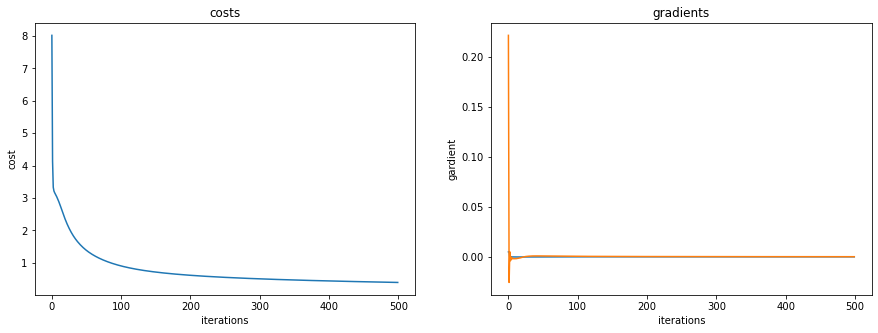

In [17]:
plot_cost_gradient(losses, gradients)

Comparaison avec les poids W1, W2

In [18]:
computeCost(X, YY, theta[0], theta[1], hidden_layer_size, 0)

0.3957093091957816

# TODO 4 : Régularisation
Mettre à jour le calcul du coût en ajoutant le terme de régularisation et comparer les résultats (avec et sans régularisation)

In [19]:
iterations = 500
alpha = 1.5
lambda_ = 500 # we are doing batch learning which means we divide the additional regularization loss by 5000
theta_reg = [np.random.normal(0, np.sqrt(1/212), W1.shape), np.random.normal(0, np.sqrt(1/17), W2.shape)]

theta_reg, losses_reg, gradients_reg = gradientDescent(X, YY, theta_reg, alpha, iterations, lambda_=1)

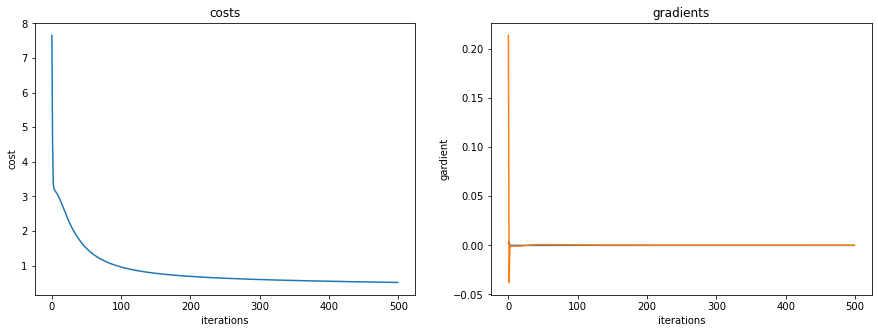

In [20]:
plot_cost_gradient(losses_reg, gradients_reg)

In [21]:
computeCost(X, YY, theta_reg[0], theta_reg[1], hidden_layer_size, 0)

0.42484199929567235

l'erreur est un peu plus élevée que celle sans régularisation. La précision est plus basse aussi.

# TODO 5 : Prédiction

Appliquer une propagation en avant en utilisant les paramètres données pour prédir les classes de l'ensemble d'apprentissage.



In [22]:
def predict(W1, W2, X):
    
    # appliquer une propagation en avant
    # !--- n'oubliez pas d'appliquer la sigmoid à chaque couche afin d'avoir les probabilités ---!
    
    # prédire la classe en choisissant la probabilité maximale parmi les 10 noeuds de sortie
    h1_output = Sigmoid(X @ W1.T)
    
    intercept = np.ones((X.shape[0],1))
    h2_input = np.column_stack((intercept, h1_output))
    
    h2_output = Sigmoid(h2_input @ W2.T)
    
    y_pred = np.argmax(h2_output, axis=1)[..., np.newaxis]
    
    # the neuron outputing probability for 0 class is at the end :( ...
    #y_pred = (y_pred + 1) % 10
    
    return y_pred

La précision du modèle :

In [23]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred = predict(theta[0], theta[1], X)
precision = np.mean(y==y_pred)*100
precision

95.08

La précision du modèle avec régularisation (qui est plus bas que celui du modèle sans):

In [24]:
y_pred = predict(theta_reg[0], theta_reg[1], X)
precision = np.mean(y==y_pred)*100
precision

94.69999999999999

# optionnel 1 : Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

In [25]:
clf = MLPClassifier(solver='sgd', alpha=0.01, activation='logistic', max_iter=5000,
        hidden_layer_sizes=(25,), random_state=42)
clf.fit(X[:, 1:], YY)

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(25,),
              max_iter=5000, random_state=42, solver='sgd')

In [26]:
y_pred = np.argmax(clf.predict(X[:, 1:]), axis=1)[..., np.newaxis]
precision = np.mean(y==y_pred)*100
precision

90.06

In [27]:
clf.score(X[:, 1:], YY) * 100

89.22

# Optionnel 2 : Visualisation des poids
    
La visualisation de poids permet de voir quel partie du réseau est activé et pour quelle classe.
Il est possible de visulaiser les paramètres theta1 . 
Ceci peut se faire en utilisant un reshape de ces paramètres afin d'avoir 25 images de taille 20x20 (n'oubliez pas d'ignorer la premuère colonne, celle du biais)

In [28]:
def visualize_weights(w1, w2):
    plt.figure(figsize=(50, 20))
    for i in range(w1.shape[0]):
        plt.subplot(3, 13, i + 1)
        plt.imshow(np.reshape(w1[i][1:], (20, 20)))
    for i in range(w2.shape[0]):
        plt.subplot(3, 13, w1.shape[0] + i + 2)
        plt.imshow(np.reshape(w2[i][1:], (-1, 1)))

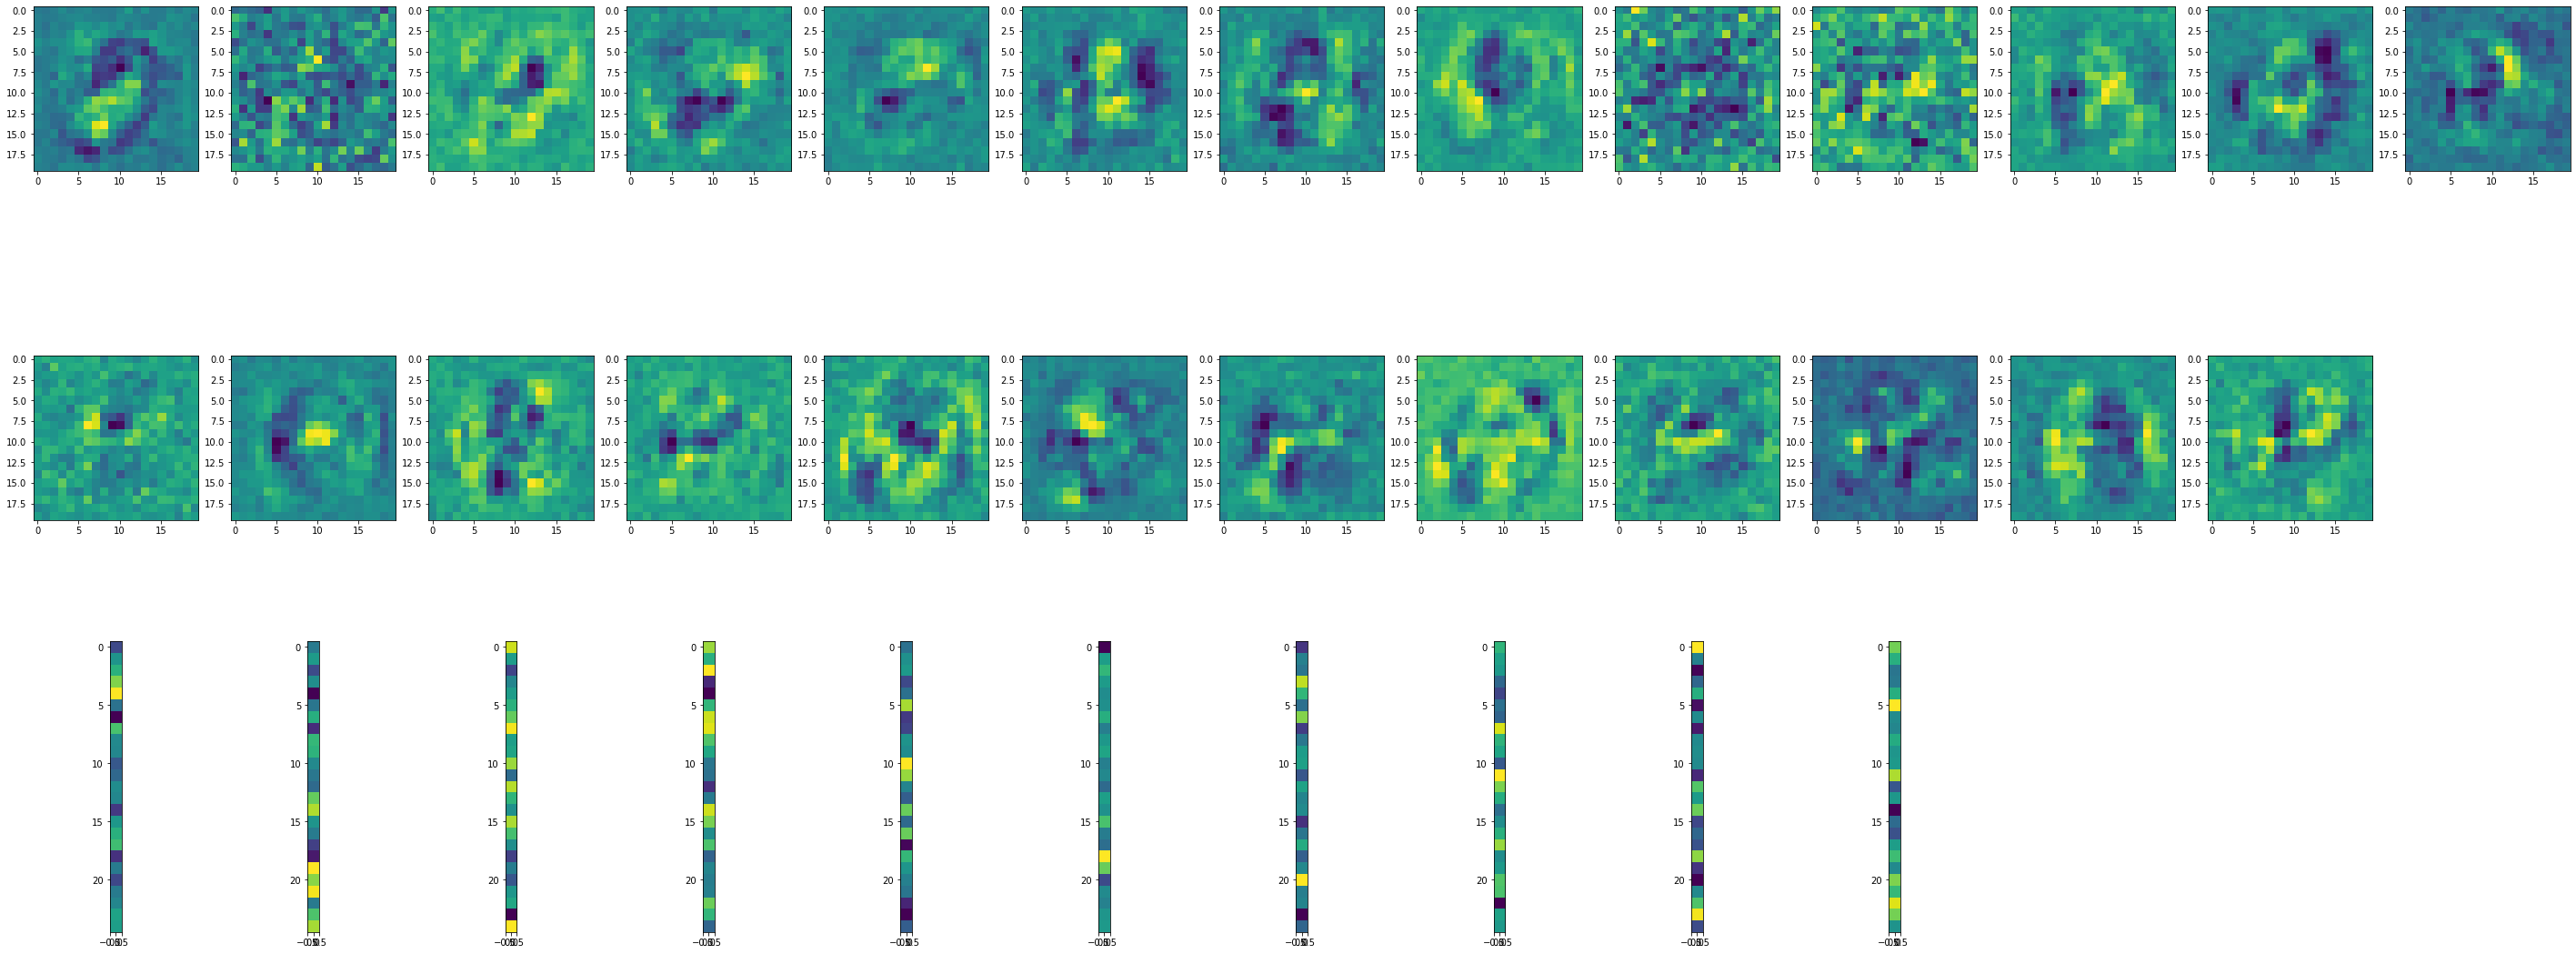

In [29]:
visualize_weights(theta[0], theta[1])

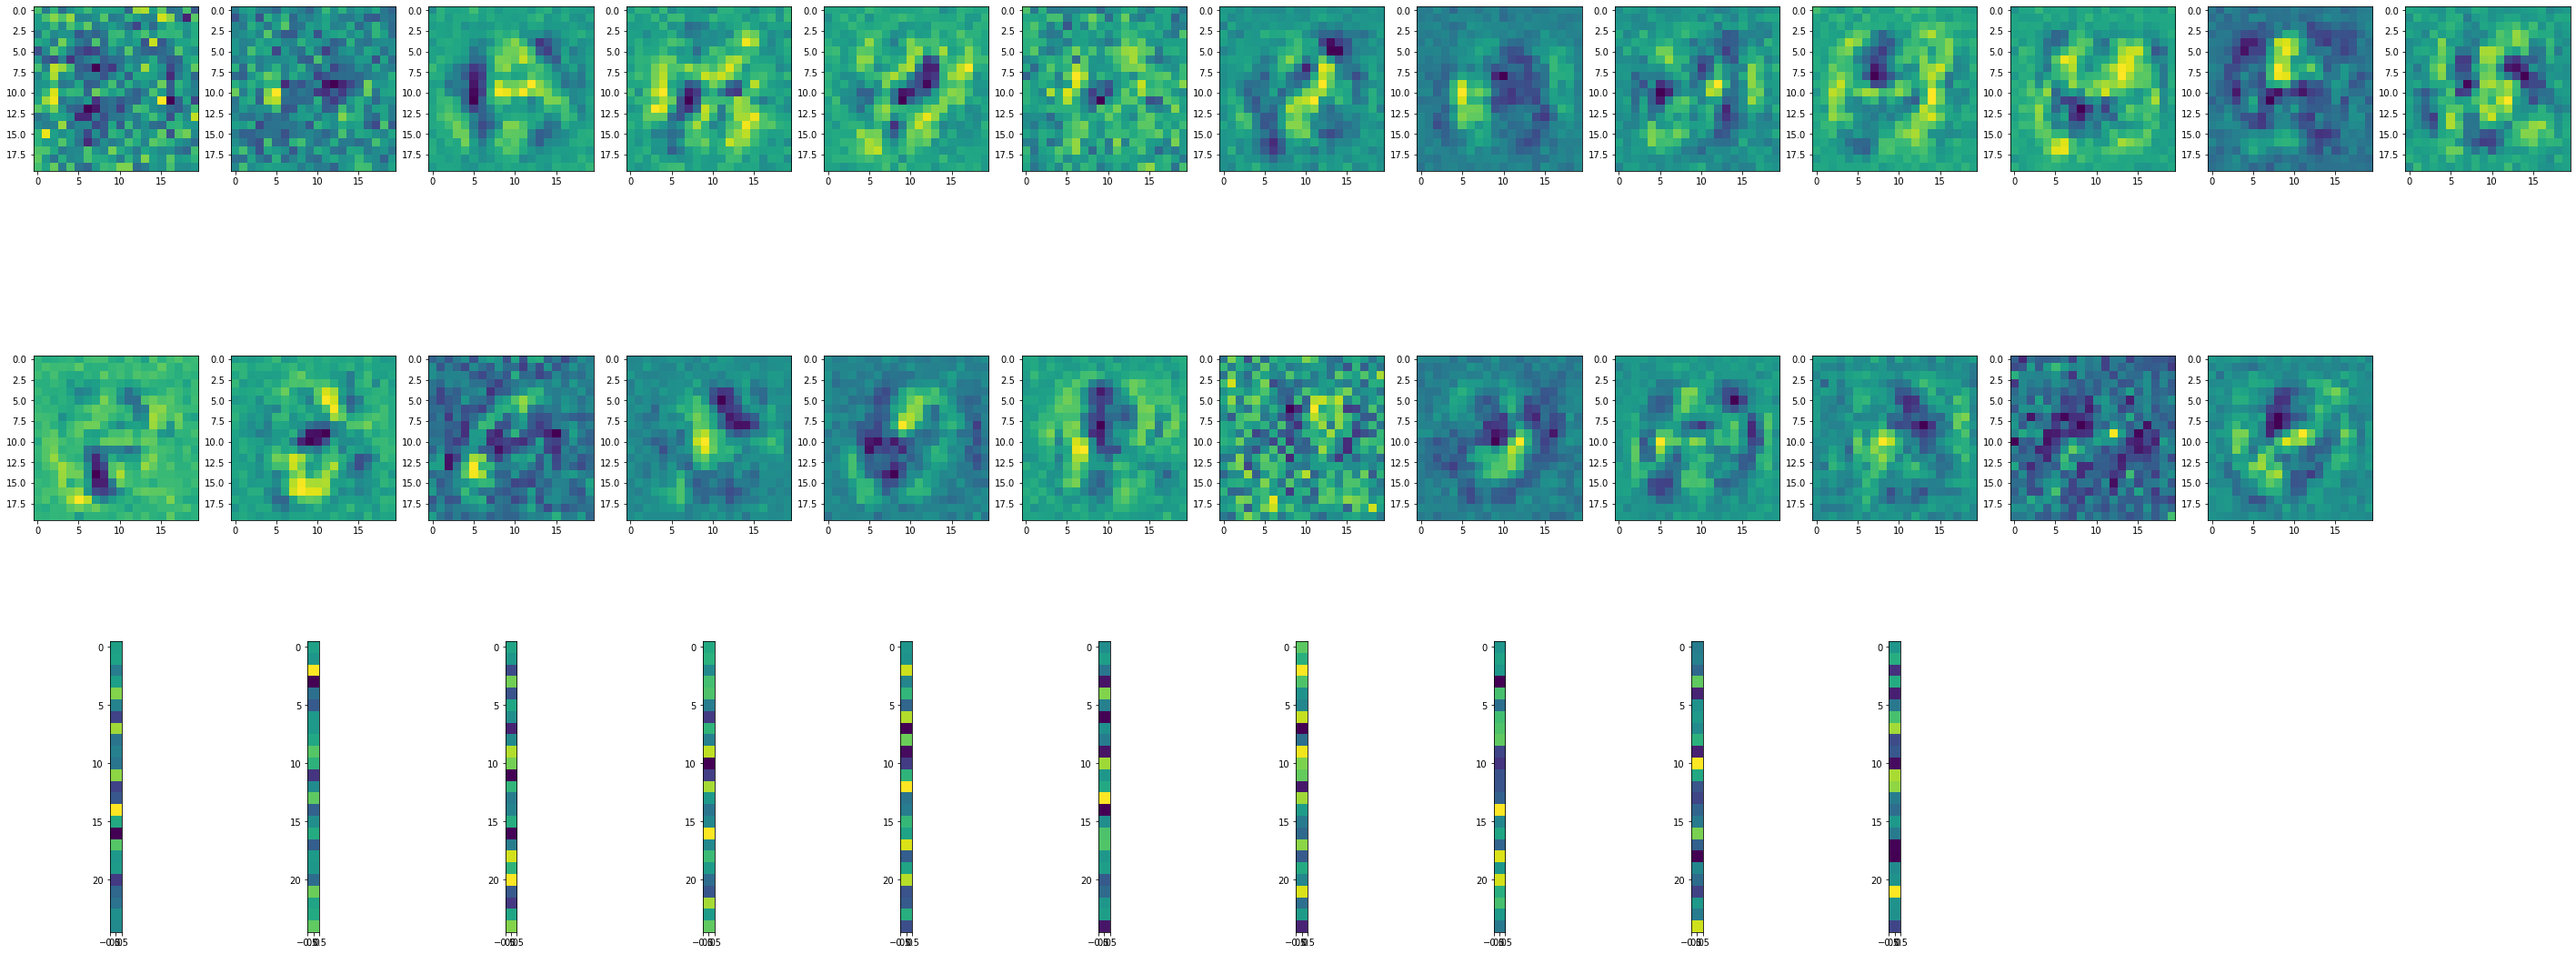

In [30]:
visualize_weights(theta_reg[0], theta_reg[1])

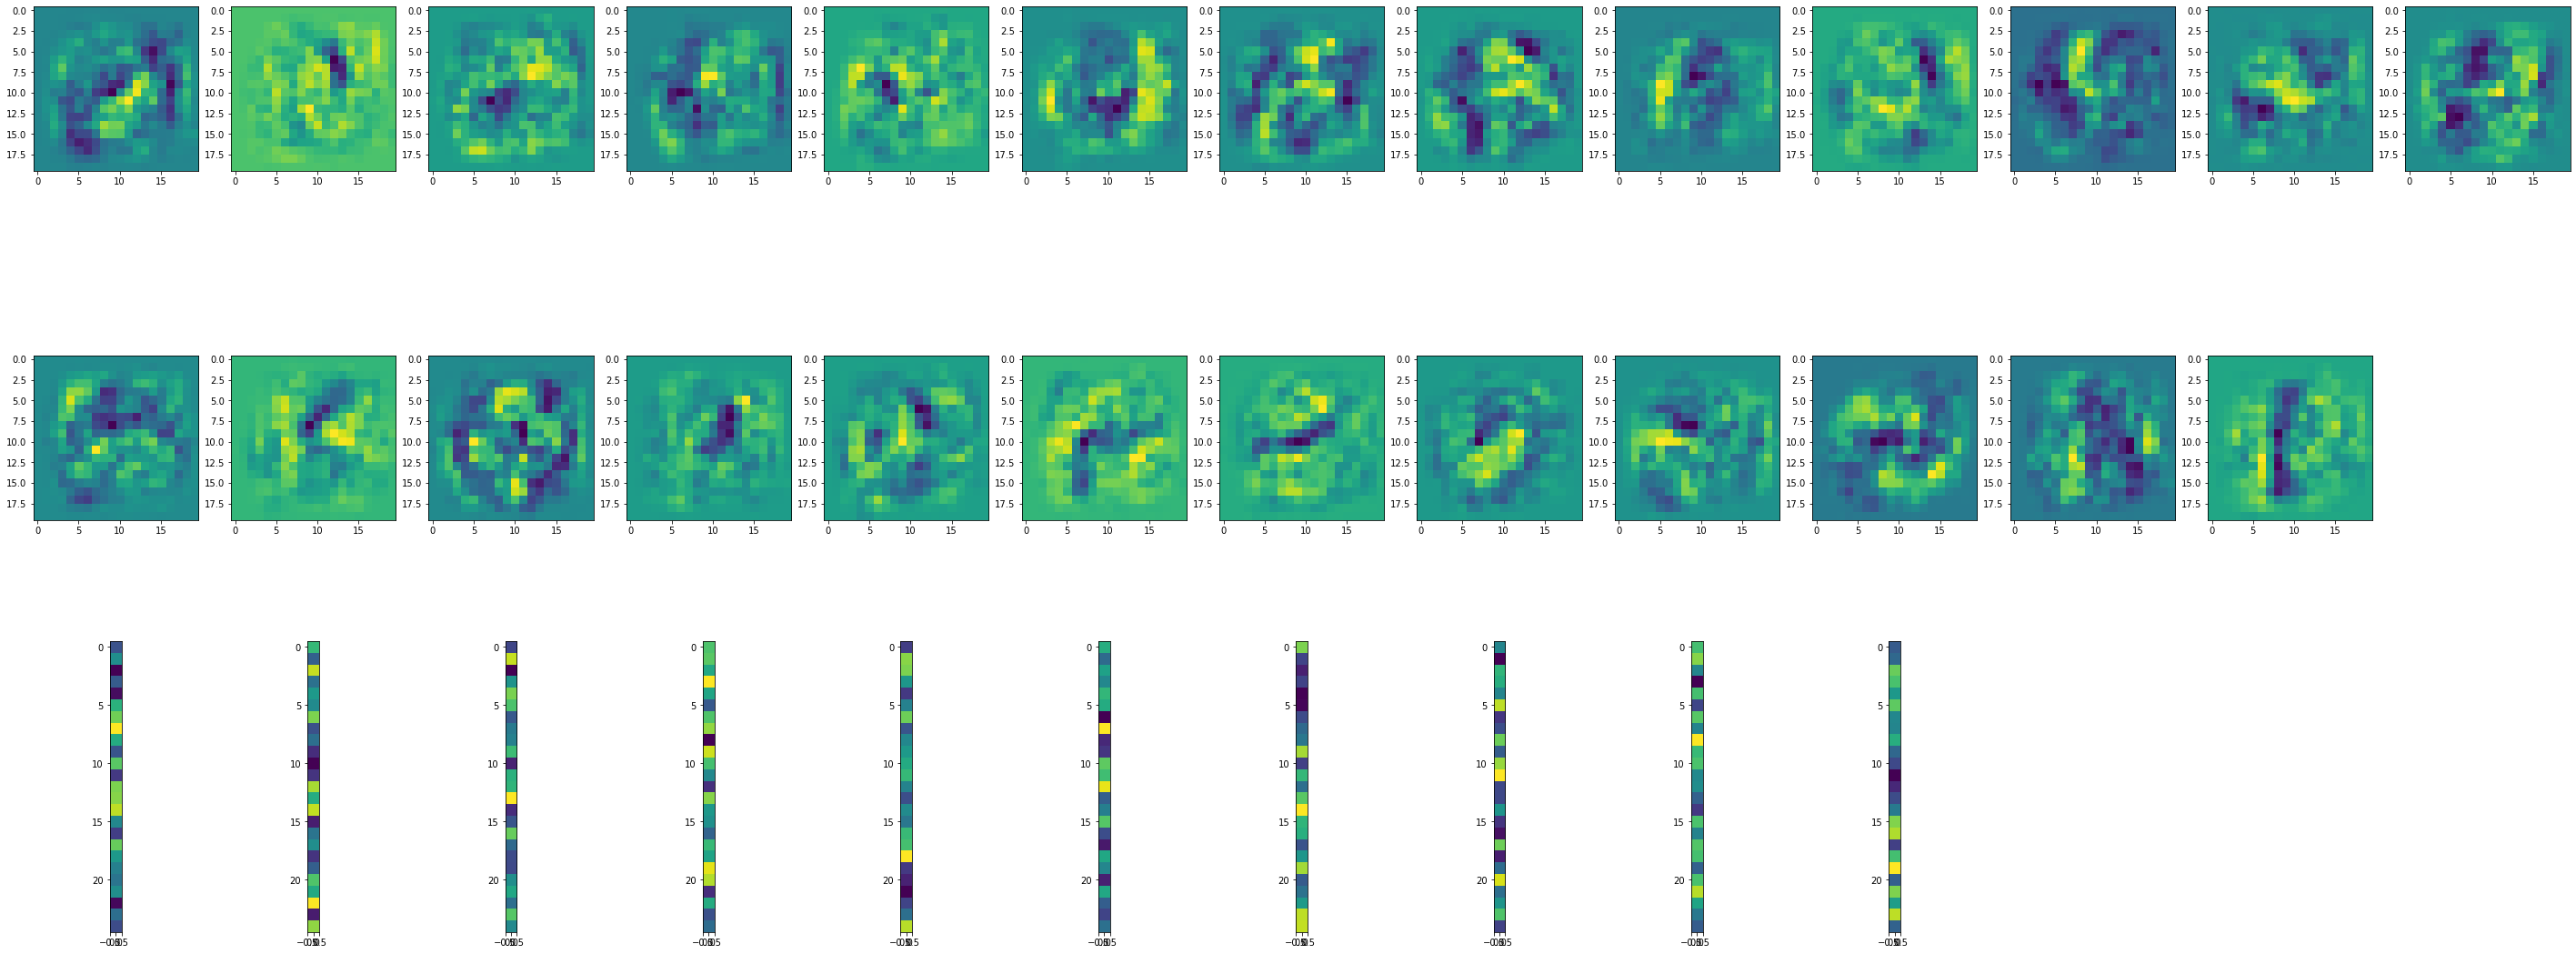

In [31]:
visualize_weights(W1, W2)

# Optionnel 3 : Renforcement de l'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

Utilisation du mini-batch learning (avec l'initialisation de Glorot) :

In [32]:
batch_size = 40
iterations = 300
alpha = 0.1
theta_batch = [np.random.normal(0, np.sqrt(1/212), W1.shape), np.random.normal(0, np.sqrt(1/17), W2.shape)]

losses_batch, gradients_batch = [], []
for _ in range(iterations):
    for i in range(int(X.shape[0] / batch_size)):
        batch_start = i * batch_size
        batch_end = batch_start + batch_size
        loss, grad = NNCostFunction(X[batch_start: batch_end], YY[batch_start: batch_end],
                                    theta_batch[0], theta_batch[1], hidden_layer_size)

        theta_batch[0] = theta_batch[0] - alpha * grad[0]
        theta_batch[1] = theta_batch[1] - alpha * grad[1]

        losses_batch.append(loss)
        gradients_batch.append((grad[0].mean(), grad[1].mean()))

losses_batch, gradients_batch = np.asarray(losses_batch), np.asarray(gradients_batch)

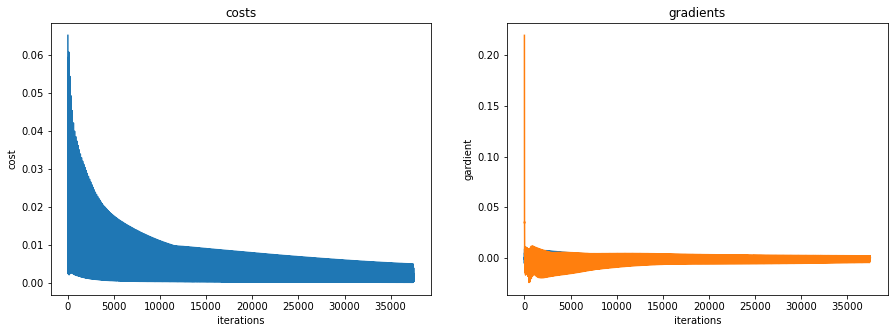

In [33]:
plot_cost_gradient(losses_batch, gradients_batch)

In [34]:
computeCost(X, YY, theta_batch[0], theta_batch[1], hidden_layer_size, 0)

0.18636133960238627

In [35]:
y_pred = predict(theta_batch[0], theta_batch[1], X)
precision = np.mean(y==y_pred)*100
precision

98.32

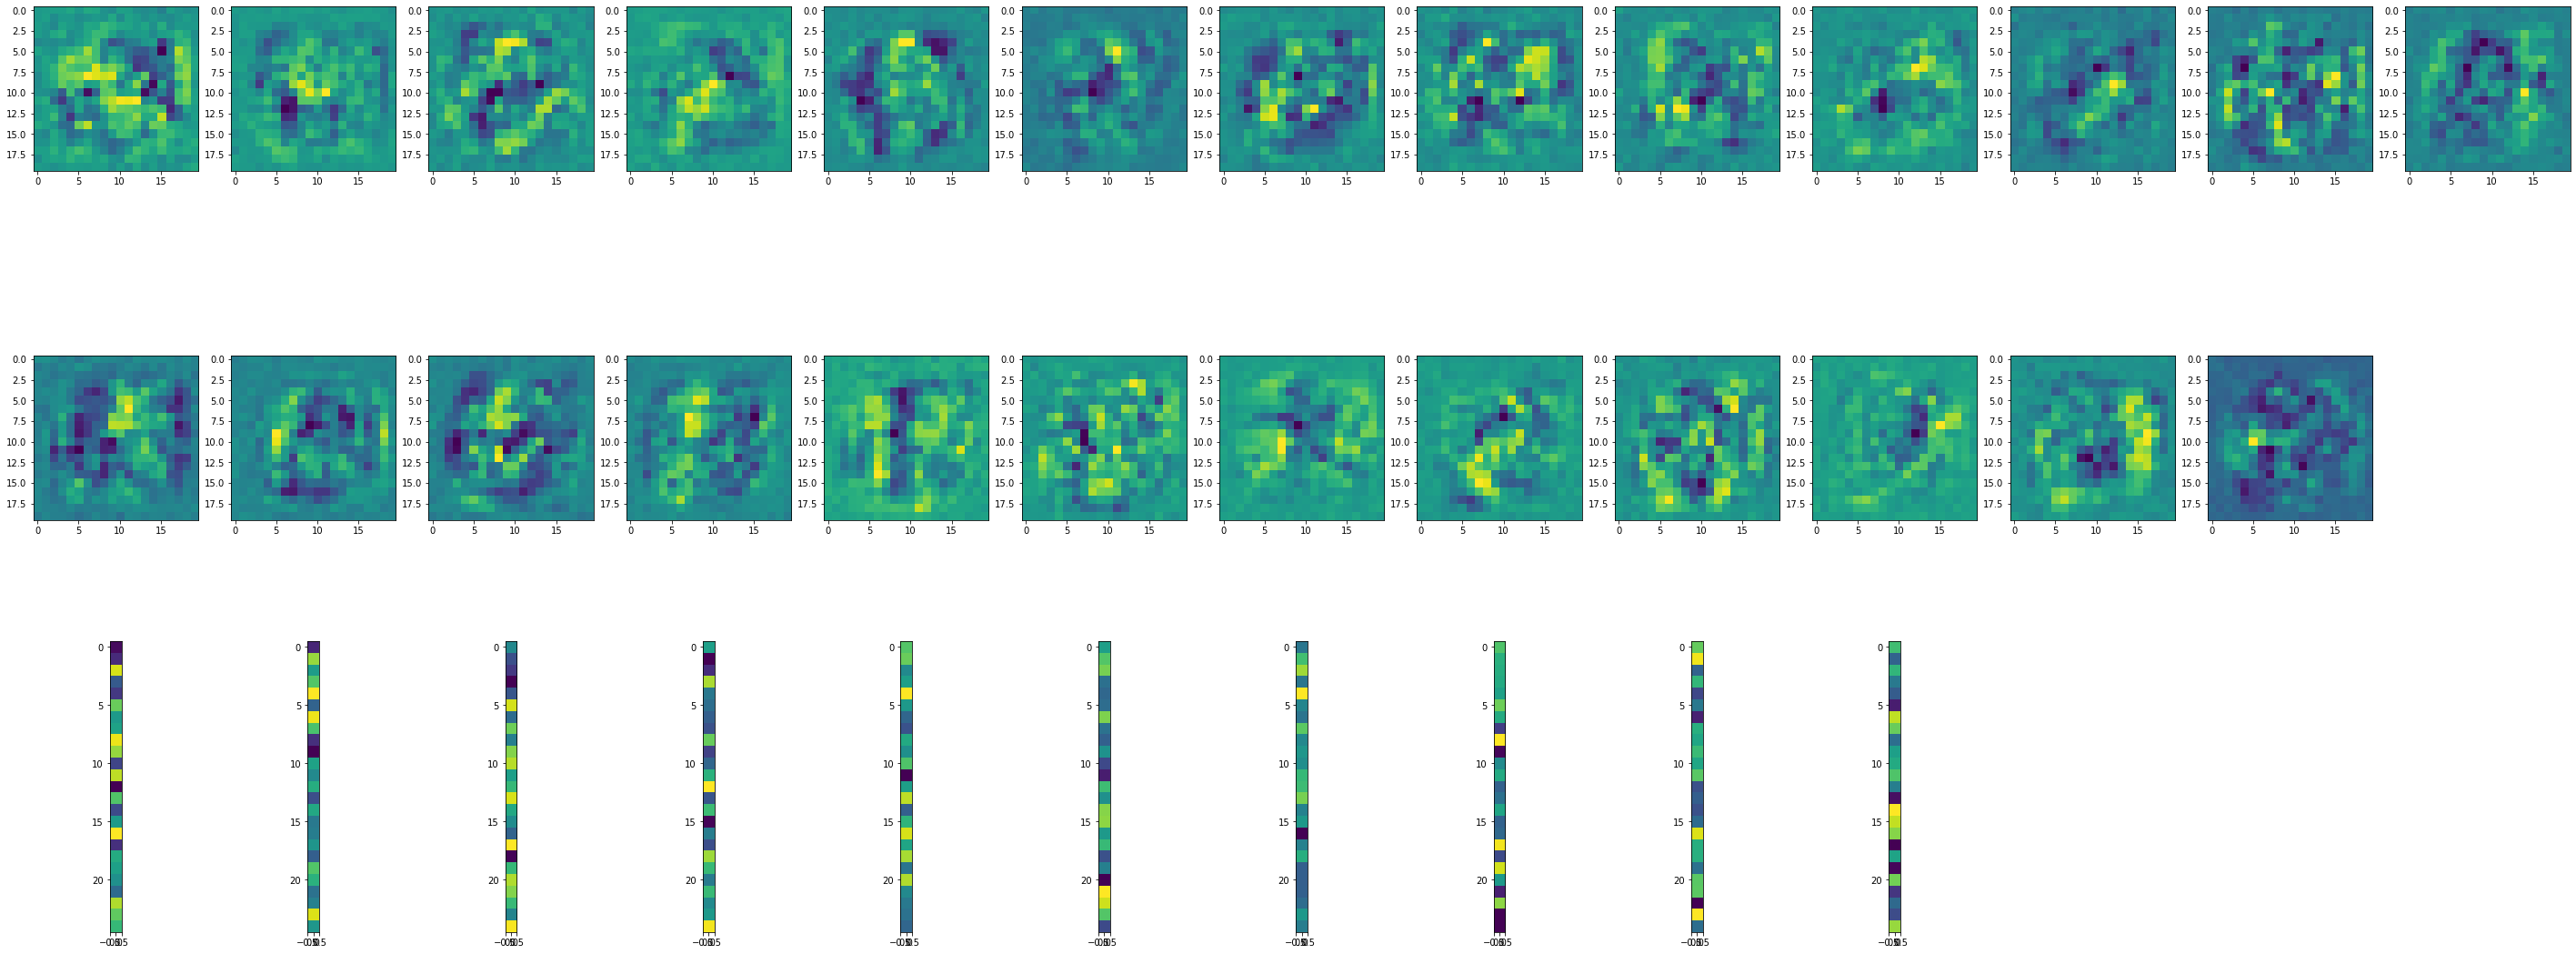

In [36]:
visualize_weights(theta_batch[0], theta_batch[1])

Nous obetons bien une meilleure précision avec cette technique.

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 29Avril 2022 à 22h


# bonne chance